###GOAL :

We have a fairly large database (lines), which contains several variables (13). Example: signup_time: "registration time", purchase_time: "purchase time" ... etc.

The purpose of this project is to detect the fraudulent actions that are represented in the column of the categorical variable "class": fraud / not fraud.

To do this, one must first make an exploratory analysis of the data, to know for example the distributions of our population by age, sex, country ...

Then do a preprocessing of the data, namely, manage the missing values, transform the qualitative data to digital data through dummification and finally normalize the quantitative variables in order to have the same data distribution.

The next step is to design models that must be able to identify fraudulent activities in advance in order to block them and thus reduce the rate of fraudulent activity. In this perspective, we will start with a logistic regression model, in order to predict the best possible fraud, and depending on the scores, we will try other models to find the one or those that will generalize the best.


### Steps :
#### 1_ Exploratory analysis
#### 2_ Preprocessing & Feature engineering
#### 3_  Modeling  



In [0]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

In [0]:
from google.colab import files
uploaded = files.upload()

In [0]:
df = pd.read_csv("df1_country.csv") 

In [0]:
df.head()

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown
4,4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [0]:
df.describe(include='all')

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
count,151112.000000,151112.000000,151112,151112,151112.000000,151112,151112,151112,151112,151112.000000,1.511120e+05,151112.000000,151112
unique,NaN,NaN,151112,150679,NaN,137956,3,5,2,NaN,NaN,NaN,182
top,NaN,NaN,2015-01-29 07:15:59,2015-06-08 09:42:04,NaN,EQYVNEGOFLAWK,SEO,Chrome,M,NaN,NaN,NaN,United States
freq,NaN,NaN,1,3,NaN,20,60615,61432,88293,NaN,NaN,NaN,58049
mean,75555.500000,200171.040970,NaN,NaN,36.935372,NaN,NaN,NaN,NaN,33.140704,2.152145e+09,0.093646,NaN
std,43622.421276,115369.285024,NaN,NaN,18.322762,NaN,NaN,NaN,NaN,8.617733,1.248497e+09,0.291336,NaN
min,0.000000,2.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,18.000000,5.209350e+04,0.000000,NaN
25%,37777.750000,100642.500000,NaN,NaN,22.000000,NaN,NaN,NaN,NaN,27.000000,1.085934e+09,0.000000,NaN
50%,75555.500000,199958.000000,NaN,NaN,35.000000,NaN,NaN,NaN,NaN,33.000000,2.154770e+09,0.000000,NaN
75%,113333.250000,300054.000000,NaN,NaN,49.000000,NaN,NaN,NaN,NaN,39.000000,3.243258e+09,0.000000,NaN


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 13 columns):
Unnamed: 0        151112 non-null int64
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
country           151112 non-null object
dtypes: float64(1), int64(5), object(7)
memory usage: 15.0+ MB


###1_ Exploratory analysis

It is interesting first to look at the class distribution

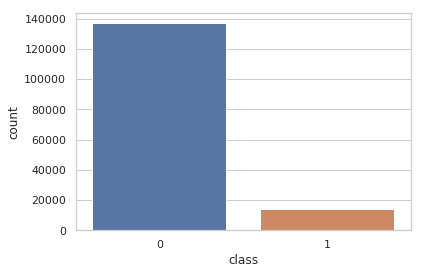

In [0]:
sns.countplot('class', data=df)

==> The dataset is particularly unbalanced. It is composed as follows: (0: 90% & 1: 10%)

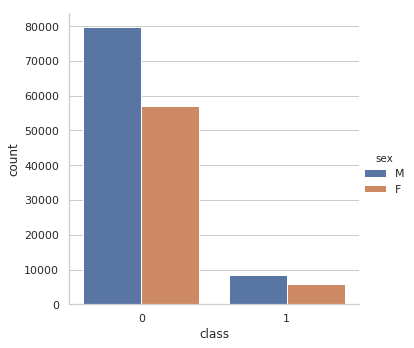

In [0]:
sns.catplot(x="class", hue="sex", kind="count", data=df)

The difference between the values (0 & 1) can not tell us much. This difference is due to the imbalance as we have seen above

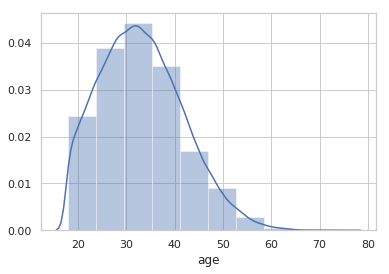

In [0]:
sns.set(style="whitegrid")
sns.distplot(df.age, bins=10)

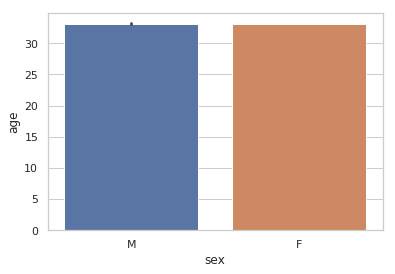

In [0]:
sns.barplot(x='sex', y="age", data = df)

 ==> The distribution of sex is almost the same in the dataset. There are as many women as there are men.

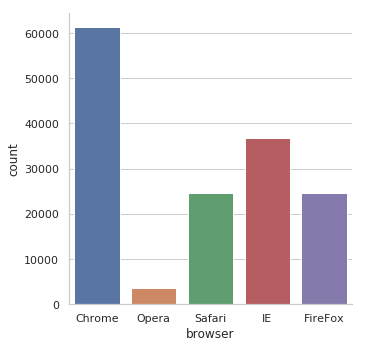

In [0]:
sns.catplot(x= 'browser', kind='count', data=df)

###We try to look at the distribution according to the classes, and according to the web browsers.
###Indeed it could have been possible that according to the web browser fraud is easier

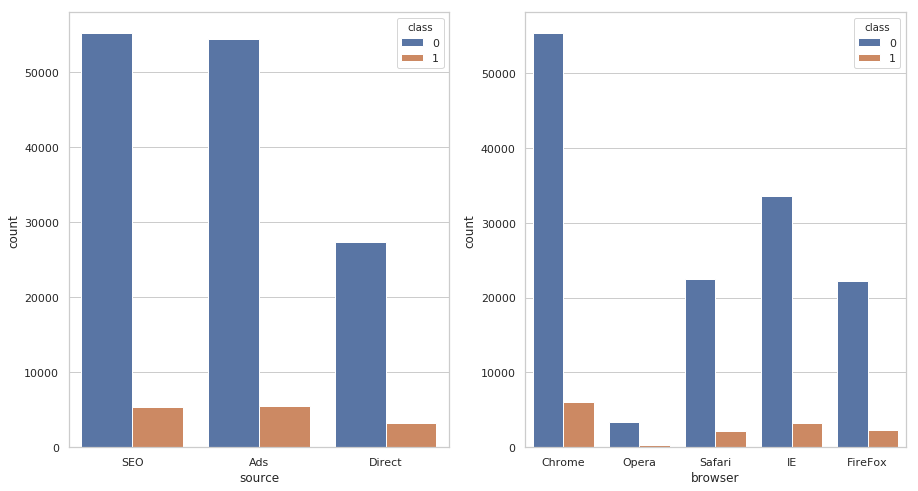

In [0]:
fig, ax = plt.subplots(1,2,figsize=(15,8))

sns.countplot('source', hue='class', data=df, ax=ax[0])
sns.countplot('browser', hue='class', data=df, ax=ax[1])

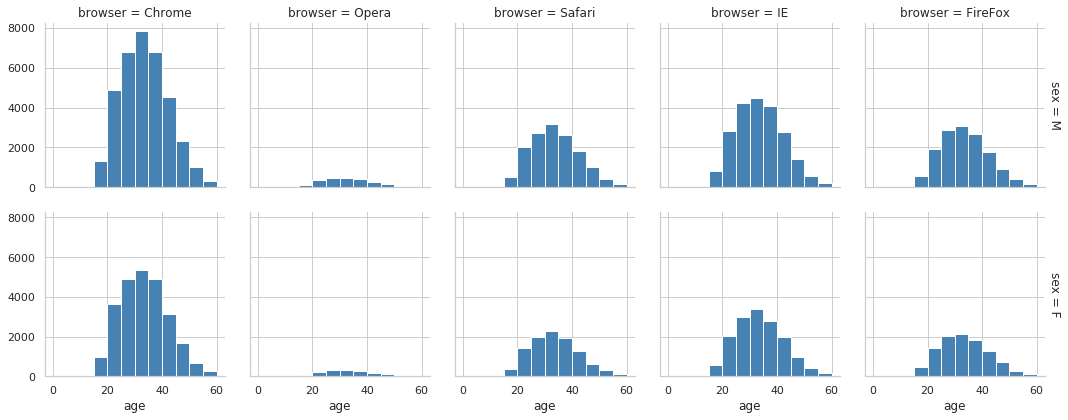

In [0]:
sns.set(style="whitegrid")
g = sns.FacetGrid(df, row="sex", col="browser", margin_titles=True)
bins = np.linspace(0, 60, 13)
g.map(plt.hist, "age", color="steelblue", bins=bins)

==>The distribution of ages remains almost the same on all browsers, it suggests that there are no browser preferences according to age, it is rather the performance of this tool that matter

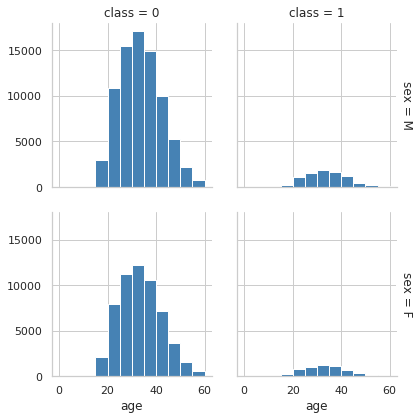

In [0]:
g = sns.FacetGrid(df, row="sex", col="class", margin_titles=True)
bins = np.linspace(0, 60, 13)
g.map(plt.hist, "age", color="steelblue", bins=bins)

==> The graph shows us that there is no specific age range for fraudsters, they can be of all ages.

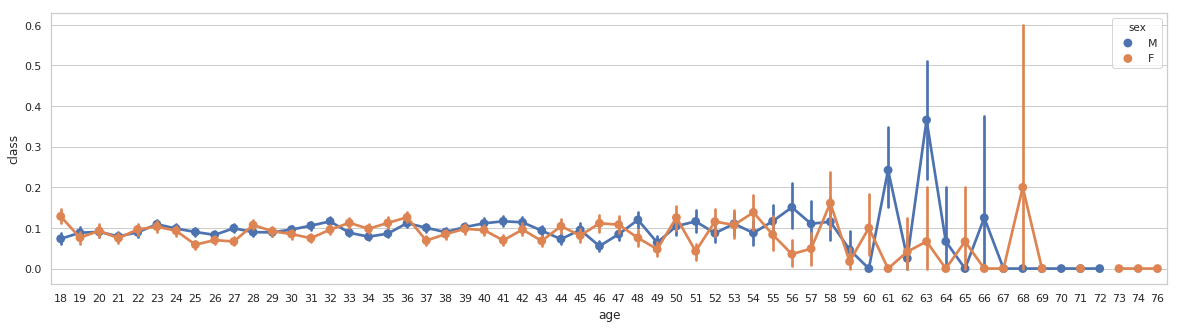

In [0]:
plt.subplots(sharey=True, figsize=(20, 5)) 
sns.pointplot(x="age", y="class", hue="sex", size="coherence", style="class", legend="full",data=df)

### 2_  Preprocessing & Feature engineering

In [0]:
a = df.groupby(df["class"]).reset_index()
a.mean()



,Unnamed: 0,user_id,purchase_value,age,ip_address
class,,,,,
0,75542.389052,200098.920123,36.929418,33.122356,2.154235e+09
1,75682.394813,200869.065366,36.993004,33.318281,2.131918e+09


In [0]:
df.groupby([pd.Grouper("sex"), 'class'])["age"].mean() 

sex  class
M    0        33.142914
     1        33.431231
F    0        33.093604
     1        33.151653
Name: age, dtype: float64

==>
- The average age for fraudsters and non-fraudsters is almost equal: 33 years
- The purchase values are almost equal for fraudsters and non-fraudsters. In the neighborhood of: 200098.00 to 200869.00

In [0]:
df.groupby(['sex', 'class']).size().reset_index()  

,sex,class,0
0,F,0,57102
1,F,1,5717
2,M,0,79859
3,M,1,8434


###We are going to rank the countries according to their fraud ratio (obviously we did not look at the countries with small occurrences, we first rank the countries with respect to their importance in dataset, then we look at the ratios

In [0]:
df['country']=df.country.apply(lambda x : str(x)) 
df.country.head()

0            Japan
1    United States
2    United States
3          Unknown
4    United States
Name: country, dtype: object

In [0]:
fraude_rate_country = ((df[df['class']==1].groupby('country')['user_id'].count()/df.groupby('country')['user_id'].count()).sort_values( ascending=False)).reset_index()                            
fraude_rate_country = pd.DataFrame(fraude_rate_country)
fraude_rate_country.head(10)                                                                                                                                                    

,country,user_id
0,Turkmenistan,1.000000
1,Namibia,0.434783
2,Sri Lanka,0.419355
3,Luxembourg,0.388889
4,Virgin Islands (U.S.),0.333333
5,Ecuador,0.264151
6,Tunisia,0.262712
7,Peru,0.260504
8,Bolivia,0.245283
9,Kuwait,0.233333


In [0]:
fraude_rate_country.drop(columns=['user_id'],inplace=True)
fraude_rate_country.head(20)

,country
0,Turkmenistan
1,Namibia
2,Sri Lanka
3,Luxembourg
4,Virgin Islands (U.S.)
5,Ecuador
6,Tunisia
7,Peru
8,Bolivia
9,Kuwait


==> Above we have the ranking of fraudulent countries. But this is not solid, because we do not have the same weight for each country in the dataset.


In [0]:
df["country"].head()

0            Japan
1    United States
2    United States
3          Unknown
4    United States
Name: country, dtype: object

In [0]:
pays  = df["country"].value_counts()/len(df.country)*100
pays.head()



United States     38.414553
Unknown           14.536238
China              7.966277
Japan              4.834825
United Kingdom     2.971306
Name: country, dtype: float64

In [0]:
country_fraude = (df[df["class"]==1].groupby(["country"])["class"].sum()).reset_index()
country_fraude = country_fraude.sort_values(by='class', ascending=False)
country_fraude.head() 

,country,class
103,United States,5551
104,Unknown,1883
17,China,1043
47,Japan,715
102,United Kingdom,477


In [0]:
df["class"].sum()


14151

In [0]:
country_fraude_rate = country_fraude["class"]/(df["class"].sum())
country_fraude_rate.head()

103    0.392269
104    0.133065
17     0.073705
47     0.050526
102    0.033708
Name: class, dtype: float64

In [0]:
dev = pd.DataFrame(df.groupby('device_id')['user_id'].count())
dev = dev.sort_values(by="user_id", ascending=False).reset_index()
dev.head(10)

,device_id,user_id
0,KIPFSCNUGOLDP,20
1,NGQCKIADMZORL,20
2,CQTUVBYIWWWBC,20
3,ITUMJCKWEYNDD,20
4,EQYVNEGOFLAWK,20
5,ZUSVMDEZRBDTX,20
6,BWSMVSLCJXMCM,19
7,IGKYVZDBEGALB,19
8,EGLGSEGYPMMAM,19
9,CDFXVYHOIHPYP,19


####Above we have grouped the device_id by user_id to see if the tuilisation of a currency more times for fraudulent purposes

In [0]:
df = df.merge(dev, on='device_id', left_index=False, right_index=False, how='inner')
df_US = df_US.merge(dev, on='device_id',left_index=False, right_index=False)
df_nan = df_nan.merge(dev, on='device_id', left_index=False, right_index=False)
df_reste = df_reste.merge(dev, on='device_id', left_index=False, right_index=False)

print("df", df.head(),"\n")
print("df_US", df_US.head(),"\n")
print("df_nan", df_nan.head(),"\n")
print("df_reste", df_reste.head(),"\n")

df    Unnamed: 0  user_id_x          signup_time  ... class        country user_id_y
0           0      22058  2015-02-24 22:55:49  ...     0          Japan         1
1           1     333320  2015-06-07 20:39:50  ...     0  United States         1
2           2       1359  2015-01-01 18:52:44  ...     1  United States        12
3        2626      48288  2015-01-01 18:52:41  ...     1  United States        12
4       22106     128706  2015-01-01 18:52:40  ...     1  United States        12

[5 rows x 14 columns] 

df_US    Unnamed: 0  user_id_x          signup_time  ... class        country user_id_y
0           1     333320  2015-06-07 20:39:50  ...     0  United States         1
1           2       1359  2015-01-01 18:52:44  ...     1  United States        12
2        2626      48288  2015-01-01 18:52:41  ...     1  United States        12
3       22106     128706  2015-01-01 18:52:40  ...     1  United States        12
4       32909     260959  2015-01-01 18:52:39  ...     1  United

Text(0.5, 1.0, 'DF reste du dataframe')

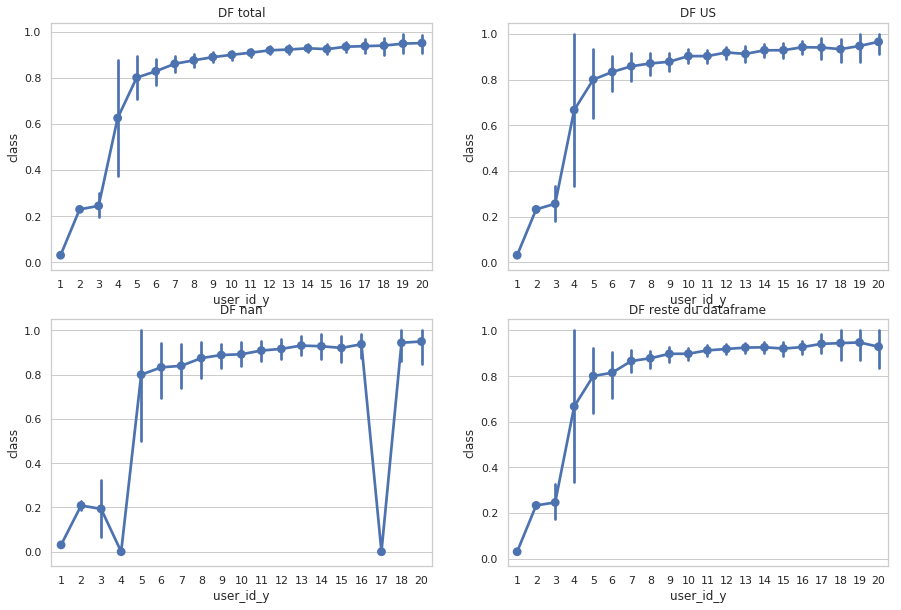

In [0]:
f, ax = plt.subplots(2,2,figsize=(15,10))

sns.pointplot(x='user_id_y',y='class', data = df, height=20, logistic=True, ax=ax[0][0])
ax[0][0].set_title("DF total")

sns.pointplot(x='user_id_y',y='class', data = df_US, height=20, logistic=True, ax=ax[0][1])
ax[0][1].set_title("DF US")

sns.pointplot(x="user_id_y",y='class', data = df_nan, height=20, logistic=True, ax=ax[1][0])
ax[1][0].set_title("DF nan")

sns.pointplot(x="user_id_y",y='class', data = df_reste, height=20, logistic=True, ax=ax[1][1])
ax[1][1].set_title("DF reste du dataframe")

 If the same currency is used more than four times, there will be a high chance of fraud. It looks a lot like the right of the elbow

We will create categories for the used devices:

_ Safe: Devices used between 1 and 3

_ Not Sure: Devices used 4 times

_ Dangerous: The devices used 5 or more times



In [0]:
df['Alerte'] = df.user_id_y.apply(lambda x : 'safe' if x<=3 else ( 'not_sure' if x==4 else 'dangerous'))

In [0]:
df.head()

,Unnamed: 0,user_id_x,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,user_id_y,Alerte
0,0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,safe
1,1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,safe
2,2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,dangerous
3,2626,48288,2015-01-01 18:52:41,2015-01-01 18:52:42,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,dangerous
4,22106,128706,2015-01-01 18:52:40,2015-01-01 18:52:41,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,dangerous


In [0]:
df.country.shape

(151112,)

In [0]:
df.signup_time.head()


0    2015-02-24 22:55:49
1    2015-06-07 20:39:50
2    2015-01-01 18:52:44
3    2015-01-01 18:52:41
4    2015-01-01 18:52:40
Name: signup_time, dtype: object

In [0]:
df['signup_time'] = pd.to_datetime(df['signup_time'])

In [0]:
df.signup_time.head()

0   2015-02-24 22:55:49
1   2015-06-07 20:39:50
2   2015-01-01 18:52:44
3   2015-01-01 18:52:41
4   2015-01-01 18:52:40
Name: signup_time, dtype: datetime64[ns]

In [0]:
df['purchase_time'].dtypes

dtype('O')

In [0]:
df['purchase_time'] = pd.to_datetime(df['purchase_time'])

In [0]:
df['purchase_time'].head()

0   2015-04-18 02:47:11
1   2015-06-08 01:38:54
2   2015-01-01 18:52:45
3   2015-01-01 18:52:42
4   2015-01-01 18:52:41
Name: purchase_time, dtype: datetime64[ns]

Calculation of the duration between the time of registration and the time of purchase


In [0]:
df["duration"] = df['purchase_time'] - df['signup_time']

In [0]:
df["duration"].head()

0   52 days 03:51:22
1    0 days 04:59:04
2    0 days 00:00:01
3    0 days 00:00:01
4    0 days 00:00:01
Name: duration, dtype: timedelta64[ns]

In [0]:
df.head()

,Unnamed: 0,user_id_x,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,user_id_y,Alerte,duration
0,0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,safe,52 days 03:51:22
1,1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,safe,0 days 04:59:04
2,2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,dangerous,0 days 00:00:01
3,2626,48288,2015-01-01 18:52:41,2015-01-01 18:52:42,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,dangerous,0 days 00:00:01
4,22106,128706,2015-01-01 18:52:40,2015-01-01 18:52:41,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,dangerous,0 days 00:00:01


Transformation of the variable duration in seconds to obtain the same norm in order to be able to train it in our model

In [0]:

df["duration_second"] = df["duration"].apply(lambda x: x.total_seconds())

In [0]:
df.head()

,Unnamed: 0,user_id_x,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,user_id_y,Alerte,duration,duration_second
0,0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,safe,52 days 03:51:22,4506682.0
1,1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,safe,0 days 04:59:04,17944.0
2,2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,dangerous,0 days 00:00:01,1.0
3,2626,48288,2015-01-01 18:52:41,2015-01-01 18:52:42,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,dangerous,0 days 00:00:01,1.0
4,22106,128706,2015-01-01 18:52:40,2015-01-01 18:52:41,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,dangerous,0 days 00:00:01,1.0


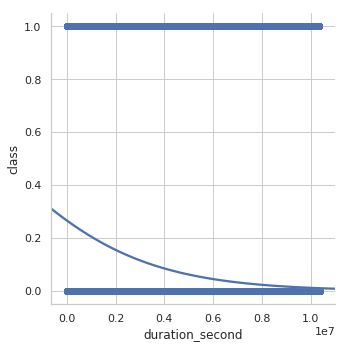

In [0]:
sns.set(style="whitegrid")
sns.lmplot(x='duration_second', y='class', logistic=True, data=df)

==> The shorter the time between registration and purchase, the greater the chances of fraud (35%)

Separation of schedules according to the periods of the day

In [0]:
df['period'] = pd.cut(df.purchase_time.dt.hour,
              [0,6,12,18,24],
              labels=['Night','Morning','Afternoon','Evening'],
              include_lowest=True)

In [0]:
df.head()

,Unnamed: 0,user_id_x,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,user_id_y,Alerte,duration,duration_second,period
0,0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,safe,52 days 03:51:22,4506682.0,Night
1,1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,safe,0 days 04:59:04,17944.0,Night
2,2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,dangerous,0 days 00:00:01,1.0,Afternoon
3,2626,48288,2015-01-01 18:52:41,2015-01-01 18:52:42,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,dangerous,0 days 00:00:01,1.0,Afternoon
4,22106,128706,2015-01-01 18:52:40,2015-01-01 18:52:41,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,dangerous,0 days 00:00:01,1.0,Afternoon


Calculate the time between the time of registration and the time of purchase, in days, hours, minutes and seconds

In [0]:
df['diff_jours'] = df['duration'].apply(lambda x : x.days)
df['diff_heures'] = df['duration'].apply(lambda x : x.components.hours)
df['diff_minutes'] = df['duration'].apply(lambda x : x.components.minutes)
df['diff_secondes'] = df['duration'].apply(lambda x : x.components.seconds)

In [0]:
df.head()

,Unnamed: 0,user_id_x,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,user_id_y,Alerte,duration,duration_second,period,diff_jours,diff_heures,diff_minutes,diff_secondes
0,0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,safe,52 days 03:51:22,4506682.0,Night,52,3,51,22
1,1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,safe,0 days 04:59:04,17944.0,Night,0,4,59,4
2,2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,dangerous,0 days 00:00:01,1.0,Afternoon,0,0,0,1
3,2626,48288,2015-01-01 18:52:41,2015-01-01 18:52:42,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,dangerous,0 days 00:00:01,1.0,Afternoon,0,0,0,1
4,22106,128706,2015-01-01 18:52:40,2015-01-01 18:52:41,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,dangerous,0 days 00:00:01,1.0,Afternoon,0,0,0,1


Deleting unnecessary variables

In [0]:

df['country'] = df['country'].str.replace('Unknown', 'nan')        

In [0]:
df['country'].value_counts()

United States                      58049
nan                                21966
China                              12038
Japan                               7306
United Kingdom                      4490
Korea Republic of                   4162
Germany                             3646
France                              3161
Canada                              2975
Brazil                              2961
Italy                               1944
Australia                           1844
Netherlands                         1680
Russian Federation                  1616
India                               1310
Taiwan; Republic of China (ROC)     1237
Mexico                              1121
Sweden                              1090
Spain                               1027
South Africa                         838
Switzerland                          785
Poland                               729
Argentina                            661
Indonesia                            649
Norway          

In [0]:
df_new = df.drop(['Unnamed: 0', 'user_id_y', 'signup_time', 'purchase_time',"device_id", "ip_address", "duration"], axis=1)
df_new.head()

,user_id_x,purchase_value,source,browser,sex,age,class,country,Alerte,duration_second,period,diff_jours,diff_heures,diff_minutes,diff_secondes
0,22058,34,SEO,Chrome,M,39,0,Japan,safe,4506682.0,Night,52,3,51,22
1,333320,16,Ads,Chrome,F,53,0,United States,safe,17944.0,Night,0,4,59,4
2,1359,15,SEO,Opera,M,53,1,United States,dangerous,1.0,Afternoon,0,0,0,1
3,48288,15,SEO,Opera,M,53,1,United States,dangerous,1.0,Afternoon,0,0,0,1
4,128706,15,SEO,Opera,M,53,1,United States,dangerous,1.0,Afternoon,0,0,0,1


In [0]:
df_new.isnull().sum()/len(df_new)

user_id_x          0.0
purchase_value     0.0
source             0.0
browser            0.0
sex                0.0
age                0.0
class              0.0
country            0.0
Alerte             0.0
duration_second    0.0
period             0.0
diff_jours         0.0
diff_heures        0.0
diff_minutes       0.0
diff_secondes      0.0
dtype: float64

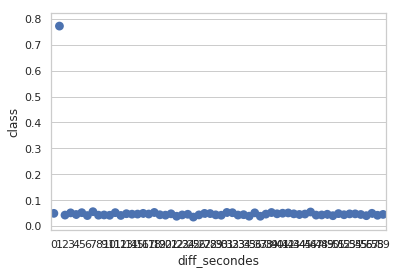

In [0]:
#f, ax = plt.subplots(1,1,figsize=(10,10))
sns.pointplot(x='diff_secondes', y ='class', logistic=True, data=df, join=None)

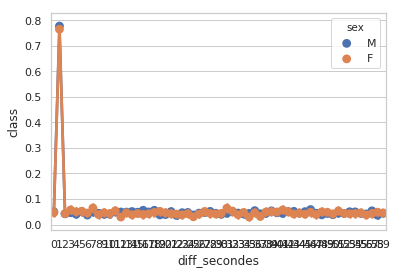

In [0]:
sns.pointplot(x='diff_secondes', y='class', hue="sex",logistic = True, data=df_new)

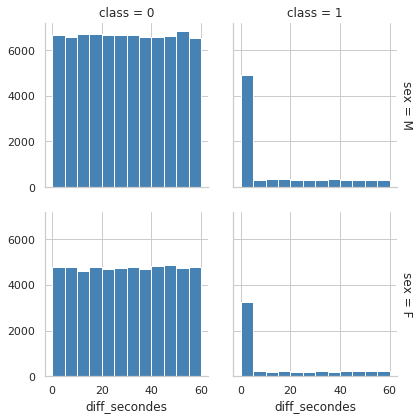

In [0]:
g = sns.FacetGrid(df_new, row="sex", col="class", margin_titles=True)
bins = np.linspace(0, 60, 13)
g.map(plt.hist, "diff_secondes", color="steelblue", bins=bins)

==> Fraud is often done exactly right after registration

Dummify my quali variables

In [0]:
df_new = pd.get_dummies(df_new, drop_first=True, dummy_na=True)

In [0]:
df_new.head()

,user_id_x,purchase_value,age,class,duration_second,diff_jours,diff_heures,diff_minutes,diff_secondes,source_Direct,source_SEO,source_nan,browser_FireFox,browser_IE,browser_Opera,browser_Safari,browser_nan,sex_M,sex_nan,country_Albania,country_Algeria,country_Angola,country_Antigua and Barbuda,country_Argentina,country_Armenia,country_Australia,country_Austria,country_Azerbaijan,country_Bahamas,country_Bahrain,country_Bangladesh,country_Barbados,country_Belarus,country_Belgium,country_Belize,country_Benin,country_Bermuda,country_Bhutan,country_Bolivia,country_Bonaire; Sint Eustatius; Saba,...,country_Slovenia,country_South Africa,country_South Sudan,country_Spain,country_Sri Lanka,country_Sudan,country_Sweden,country_Switzerland,country_Syrian Arab Republic,country_Taiwan; Republic of China (ROC),country_Tajikistan,country_Tanzania United Republic of,country_Thailand,country_Trinidad and Tobago,country_Tunisia,country_Turkey,country_Turkmenistan,country_Uganda,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe,country_nan,country_nan,Alerte_not_sure,Alerte_safe,Alerte_nan,period_Morning,period_Afternoon,period_Evening,period_nan
0,22058,34,39,0,4506682.0,52,3,51,22,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,333320,16,53,0,17944.0,0,4,59,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,1359,15,53,1,1.0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,48288,15,53,1,1.0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,128706,15,53,1,1.0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### 3_ models prediction 

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_new, test_size=0.3, stratify = df_new['class']) 

In [0]:
train.head(3)

,user_id_x,purchase_value,age,class,duration_second,diff_jours,diff_heures,diff_minutes,diff_secondes,source_Direct,source_SEO,source_nan,browser_FireFox,browser_IE,browser_Opera,browser_Safari,browser_nan,sex_M,sex_nan,country_Albania,country_Algeria,country_Angola,country_Antigua and Barbuda,country_Argentina,country_Armenia,country_Australia,country_Austria,country_Azerbaijan,country_Bahamas,country_Bahrain,country_Bangladesh,country_Barbados,country_Belarus,country_Belgium,country_Belize,country_Benin,country_Bermuda,country_Bhutan,country_Bolivia,country_Bonaire; Sint Eustatius; Saba,...,country_Slovenia,country_South Africa,country_South Sudan,country_Spain,country_Sri Lanka,country_Sudan,country_Sweden,country_Switzerland,country_Syrian Arab Republic,country_Taiwan; Republic of China (ROC),country_Tajikistan,country_Tanzania United Republic of,country_Thailand,country_Trinidad and Tobago,country_Tunisia,country_Turkey,country_Turkmenistan,country_Uganda,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe,country_nan,country_nan,Alerte_not_sure,Alerte_safe,Alerte_nan,period_Morning,period_Afternoon,period_Evening,period_nan
2036,357753,40,27,1,1.0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
91838,128018,10,31,0,5903921.0,68,7,58,41,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
9776,96943,11,23,1,1.0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [0]:
test.head(3)

,user_id_x,purchase_value,age,class,duration_second,diff_jours,diff_heures,diff_minutes,diff_secondes,source_Direct,source_SEO,source_nan,browser_FireFox,browser_IE,browser_Opera,browser_Safari,browser_nan,sex_M,sex_nan,country_Albania,country_Algeria,country_Angola,country_Antigua and Barbuda,country_Argentina,country_Armenia,country_Australia,country_Austria,country_Azerbaijan,country_Bahamas,country_Bahrain,country_Bangladesh,country_Barbados,country_Belarus,country_Belgium,country_Belize,country_Benin,country_Bermuda,country_Bhutan,country_Bolivia,country_Bonaire; Sint Eustatius; Saba,...,country_Slovenia,country_South Africa,country_South Sudan,country_Spain,country_Sri Lanka,country_Sudan,country_Sweden,country_Switzerland,country_Syrian Arab Republic,country_Taiwan; Republic of China (ROC),country_Tajikistan,country_Tanzania United Republic of,country_Thailand,country_Trinidad and Tobago,country_Tunisia,country_Turkey,country_Turkmenistan,country_Uganda,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe,country_nan,country_nan,Alerte_not_sure,Alerte_safe,Alerte_nan,period_Morning,period_Afternoon,period_Evening,period_nan
117590,24498,11,31,0,4096816.0,47,10,0,16,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
39822,362699,44,24,0,5093621.0,58,22,53,41,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
142327,205973,50,35,0,9253886.0,107,2,31,26,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


The DataFrame and very unbalanced: (class 0 = 90% & class 1 = 10%)

---> it is necessary to take a sample for example of 50% 50%

Important:
The sample is on the training sample only. Do not do the sample on the test

In [0]:
train_class_1 = pd.DataFrame(train.loc[train["class"] == 1])
train_class_0 = pd.DataFrame(train.loc[train["class"] == 0]).sample(len(train_class_1))

In [0]:
train_new = pd.concat([train_class_1,train_class_0])

In [0]:
train_new.head(3)

,user_id_x,purchase_value,age,class,duration_second,diff_jours,diff_heures,diff_minutes,diff_secondes,source_Direct,source_SEO,source_nan,browser_FireFox,browser_IE,browser_Opera,browser_Safari,browser_nan,sex_M,sex_nan,country_Albania,country_Algeria,country_Angola,country_Antigua and Barbuda,country_Argentina,country_Armenia,country_Australia,country_Austria,country_Azerbaijan,country_Bahamas,country_Bahrain,country_Bangladesh,country_Barbados,country_Belarus,country_Belgium,country_Belize,country_Benin,country_Bermuda,country_Bhutan,country_Bolivia,country_Bonaire; Sint Eustatius; Saba,...,country_Slovenia,country_South Africa,country_South Sudan,country_Spain,country_Sri Lanka,country_Sudan,country_Sweden,country_Switzerland,country_Syrian Arab Republic,country_Taiwan; Republic of China (ROC),country_Tajikistan,country_Tanzania United Republic of,country_Thailand,country_Trinidad and Tobago,country_Tunisia,country_Turkey,country_Turkmenistan,country_Uganda,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe,country_nan,country_nan,Alerte_not_sure,Alerte_safe,Alerte_nan,period_Morning,period_Afternoon,period_Evening,period_nan
2036,357753,40,27,1,1.0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9776,96943,11,23,1,1.0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
24657,94833,19,37,1,1.0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


In [0]:
X_train = train_new.drop(["class"], axis=1)
y_train = train_new["class"] 

In [0]:
X_test = test.drop(["class"], axis=1)
y_test = test["class"] 

In [0]:
X_test.head()

,user_id_x,purchase_value,age,duration_second,diff_jours,diff_heures,diff_minutes,diff_secondes,source_Direct,source_SEO,source_nan,browser_FireFox,browser_IE,browser_Opera,browser_Safari,browser_nan,sex_M,sex_nan,country_Albania,country_Algeria,country_Angola,country_Antigua and Barbuda,country_Argentina,country_Armenia,country_Australia,country_Austria,country_Azerbaijan,country_Bahamas,country_Bahrain,country_Bangladesh,country_Barbados,country_Belarus,country_Belgium,country_Belize,country_Benin,country_Bermuda,country_Bhutan,country_Bolivia,country_Bonaire; Sint Eustatius; Saba,country_Bosnia and Herzegowina,...,country_Slovenia,country_South Africa,country_South Sudan,country_Spain,country_Sri Lanka,country_Sudan,country_Sweden,country_Switzerland,country_Syrian Arab Republic,country_Taiwan; Republic of China (ROC),country_Tajikistan,country_Tanzania United Republic of,country_Thailand,country_Trinidad and Tobago,country_Tunisia,country_Turkey,country_Turkmenistan,country_Uganda,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe,country_nan,country_nan,Alerte_not_sure,Alerte_safe,Alerte_nan,period_Morning,period_Afternoon,period_Evening,period_nan
117590,24498,11,31,4096816.0,47,10,0,16,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
39822,362699,44,24,5093621.0,58,22,53,41,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
142327,205973,50,35,9253886.0,107,2,31,26,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
37468,12852,51,32,57867.0,0,16,4,27,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
70191,130653,10,34,3528546.0,40,20,9,6,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0


Normalisation  variables 


In [0]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test) 

In [0]:
X_train

array([[ 1.35997589,  0.16002219, -0.72209606, ..., -0.58442219,
        -0.50453867,  0.        ],
       [-0.88981522, -1.41935752, -1.18538993, ...,  1.71109177,
        -0.50453867,  0.        ],
       [-0.90801644, -0.98366656,  0.43613861, ..., -0.58442219,
        -0.50453867,  0.        ],
       ...,
       [ 0.65310448, -1.36489615,  0.89943247, ..., -0.58442219,
         1.98200863,  0.        ],
       [-1.51289202, -1.47381889,  0.08866821, ..., -0.58442219,
         1.98200863,  0.        ],
       [-0.21909608, -0.22120739, -0.72209606, ..., -0.58442219,
        -0.50453867,  0.        ]])

###MODELE 1 : Logistic Regression 

In [0]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
classifier.score(X_test, y_test)

0.9470154850663961

In [0]:
from sklearn.model_selection import cross_val_score
#cross_val_score(classifier,X, y, cv=10)#.std()
cross_val_score(classifier, X_test, y_test, cv=10).mean()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

0.9510741787562782

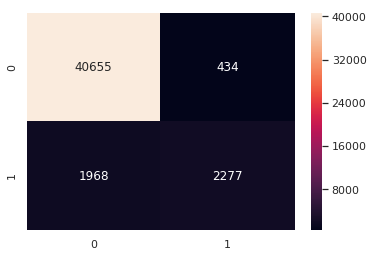

In [0]:
from sklearn.metrics import confusion_matrix
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")

==> To reduce the false positives FP and the false negative FN it is necessary to make the predictions of probabilities (y = 1, y = 0) by fixing the threshold.

In [0]:
pred_proba = classifier.predict_proba(X_test) 

In [0]:
pred_prob = pd.DataFrame()
pred_prob = pd.DataFrame(pred_proba, columns=['proba_0', 'proba_1'])
pred_prob.head()

,proba_0,proba_1
0,0.615385,0.384615
1,0.403846,0.596154
2,0.519231,0.480769
3,0.615385,0.384615
4,0.615385,0.384615


==> The threshold is fixed at 0.5, ie when the proba_1 is greater than 0.5 so there will be a fraud, and vice versa.

We will increase the threshold of the probabilities of (0.5 to 0.8), ie, if the proba_1 is greater than or equal to 0.8 there will be a fraud.


In [0]:
pred_prob['proba_1'] = pred_prob['proba_1'].apply(lambda x: 1 if x > 0.8 else 0) 

In [0]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,pred_prob['proba_1'])

0.9561477037102396

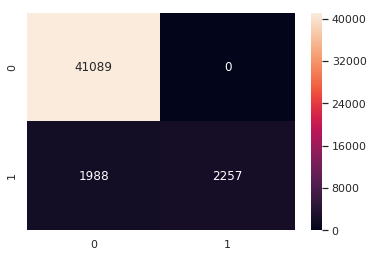

In [0]:
from sklearn.metrics import confusion_matrix
cm_1 = confusion_matrix(y_test, pred_prob['proba_1'])
sns.heatmap(cm_1, annot=True, fmt="d")

==> With probalities and a threshold of 0.8, we have decreased FP and FN

####MODEL 2 : SVM


In [0]:
from sklearn import svm
sv = svm.SVC(gamma='scale')
sv.fit(X_train, y_train)
sv.score(X_test, y_test)

0.9447655181541448

####MODEL 3 : DECISION TREE

In [0]:
from sklearn.tree import DecisionTreeClassifier
classifier_trees = DecisionTreeClassifier()
classifier_trees.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
classifier_trees.score(X_test, y_test)

0.6788061940265584

####MODEL 4 : Random Forest

Let's try to improve our score. We will do a Random Forest with 100 decision trees

In [0]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(X_train, y_train)
rf_classifier.score(X_test, y_test)

0.9496183879648828

####Grid Search to find the optimum number of trees


In [0]:
from sklearn.model_selection import GridSearchCV
params = {"n_estimators": range(20, 60)}

classifier = GridSearchCV(cv=3, estimator=rf_classifier, scoring="accuracy", n_jobs=-1, verbose=1, param_grid=params).fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.7min finished


In [0]:
classifier.best_params_

{'n_estimators': 52}

In [0]:
classifier.best_estimator_.score(X_test, y_test)

0.9421405567565183

####Model 5 : Voting

In [0]:
from sklearn.ensemble import VotingClassifier
votingC = VotingClassifier(estimators=[("DecisionTreeClassifier", classifier_trees),("Random Forest",rf_classifier),("LogisticRegression",classifier),("SVM",sv)], 
                           voting='hard', 
                           n_jobs=-1)

votingC = votingC.fit(X_train, np.ravel(y_train))

In [0]:
votingC.score(X_test, y_test)

0.9539639122954074